# MIDS W207 Fall 2017 Final Project¶
## Exploratory Data Analysis
Laura Williams, Kim Vignola, Cyprian Gascoigne  
SF Crime Classification

This notebook comprises the Exploratory Data Analysis that will inform data set up and modeling decisions. Recommendations based on this EDA include:
* adding buckets for month, holidays, and dayparts
* assessing inclusion of day of month, especially the 1st of the month 
* reassigning cases with latitude > 38 to a latitude based on district
* addressing the year 2015 as we only have data through May
* expanding the definition of holidays to include holiday weeks/weekends and eve's

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import zipfile
import matplotlib.pyplot as plt

In [3]:
# Unzip raw data into a subdirectory 
unzip_files = zipfile.ZipFile("raw_data.zip", "r")
unzip_files.extractall("raw_data")
unzip_files.close()

In [3]:
# Read CSV files into pandas dataframes
train = pd.read_csv("raw_data/train.csv")
test = pd.read_csv("raw_data/test.csv")
weather = pd.read_csv("raw_data/SF_county.csv")

#### Notable points from the dataset descriptions:
* Test data has a slightly larger standard deviation for latitude (.484 vs. .456). This may help inform geographic follow ups.
* Some dates and categories are weighted more heavily in the train data.
* There are some erroneous Y values (90 degree latitude)
* Additionally, the majority of records do not contain a resolution. This field will be removed nonetheless given that it is not present in the test data.

In [5]:
train.describe(include='all')

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
count,878049,878049,878049,878049,878049,878049,878049,878049.000000,878049.000000
unique,389257,39,879,7,10,17,23228,NaN,NaN
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,NaN,NaN
freq,185,174900,60022,133734,157182,526790,26533,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.422616,37.771020
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030354,0.456893
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.432952,37.752427
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.416420,37.775421
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.406959,37.784369


In [6]:
test.describe(include='all')

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
count,884262.000000,884262,884262,884262,884262,884262.000000,884262.000000
unique,NaN,392173,7,10,23184,NaN,NaN
top,NaN,2010-01-01 00:01:00,Friday,SOUTHERN,800 Block of BRYANT ST,NaN,NaN
freq,NaN,150,134703,157456,26984,NaN,NaN
mean,442130.500000,NaN,NaN,NaN,NaN,-122.422693,37.771476
std,255264.596206,NaN,NaN,NaN,NaN,0.030985,0.484824
min,0.000000,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,221065.250000,NaN,NaN,NaN,NaN,-122.433069,37.752374
50%,442130.500000,NaN,NaN,NaN,NaN,-122.416517,37.775421
75%,663195.750000,NaN,NaN,NaN,NaN,-122.406959,37.784353


In [7]:
# Support that the majority of records do not contain a resolution.
print(len(train.loc[train['Resolution'] == "NONE"]))

526790


In [4]:
# Look for missing values
null_values = pd.isnull(train)
columns = null_values.columns.values
for col in range(columns.shape[0]):
    print("The number of missing values in the", columns[col], "feature is",
          len(null_values.iloc[:,col][null_values.iloc[:,col]==True]))
    # print(null_values.iloc[:,col].mean()) # Can also doublecheck by looking at the mean of the Boolean array


The number of missing values in the Dates feature is 0
The number of missing values in the Category feature is 0
The number of missing values in the Descript feature is 0
The number of missing values in the DayOfWeek feature is 0
The number of missing values in the PdDistrict feature is 0
The number of missing values in the Resolution feature is 0
The number of missing values in the Address feature is 0
The number of missing values in the X feature is 0
The number of missing values in the Y feature is 0


In [24]:
# While the number of erroneous Y values is small, but the magnitude of difference is large and could create noise 
# in the data. To fix this we will reassess Lat/Long for these cases based on Districts.
print(len(train.loc[train['Y'] > 40]))

67


In [25]:
# In this EDA we will remove longitude >38 for the purposes of visualization
train = train.loc[train["Y"] < 38, :]
test = test.loc[test["Y"] < 38, :]

In [26]:
# Most of the fields in the training dataset need to be transformed to numerical values.
print(train.dtypes)

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object


In [44]:
# Review the top crime categories to identify those to include in visualizations
train["Category"].value_counts().head(10)

LARCENY/THEFT     174885
OTHER OFFENSES    126165
NON-CRIMINAL       92300
ASSAULT            76872
DRUG/NARCOTIC      53971
VEHICLE THEFT      53772
VANDALISM          44724
WARRANTS           42206
BURGLARY           36754
SUSPICIOUS OCC     31412
Name: Category, dtype: int64

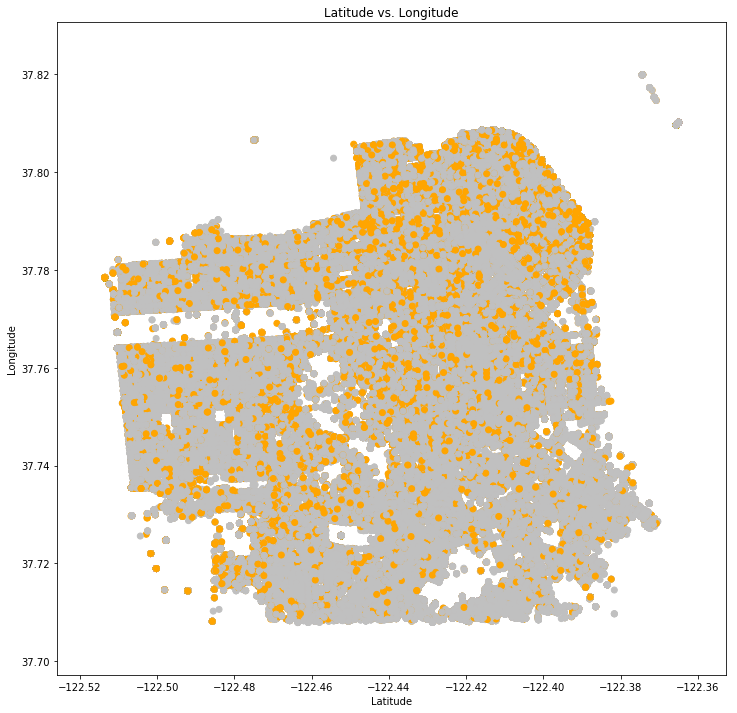

In [27]:
# The top crime category is dispersed throughout the region but does skew to the northeast of the city.
fig = plt.figure(figsize=(12,12))
plt.scatter(train["X"], train["Y"], c=['orange' if x=="LARCENY/THEFT" else 'silver' for x in train["Category"]])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Locations for Larceny/Theft')
plt.show()

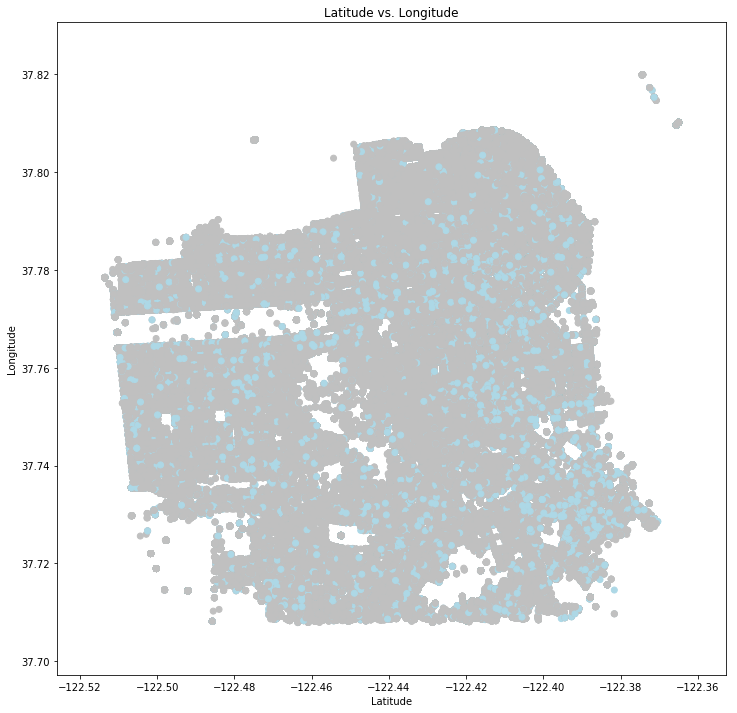

In [28]:
# The #2 Category "Other Offenses" leans toward the southeast of the city
fig = plt.figure(figsize=(12,12))
plt.scatter(train["X"], train["Y"], c=['lightblue' if x=="OTHER OFFENSES" else 'silver' for x in train["Category"]])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Locations for "Other Offenses"')
plt.show()

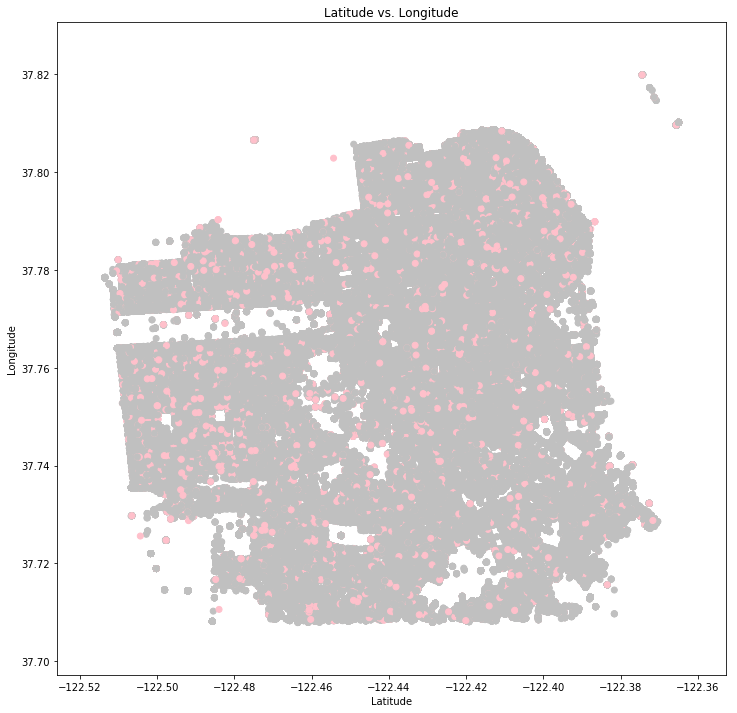

In [29]:
# The Non-Criminal Category points has relatively more activity in the west
fig = plt.figure(figsize=(12,12))
plt.scatter(train["X"], train["Y"], c=['pink' if x=="NON-CRIMINAL" else 'silver' for x in train["Category"]])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Locations for "Non-Criminal" Category')
plt.show()

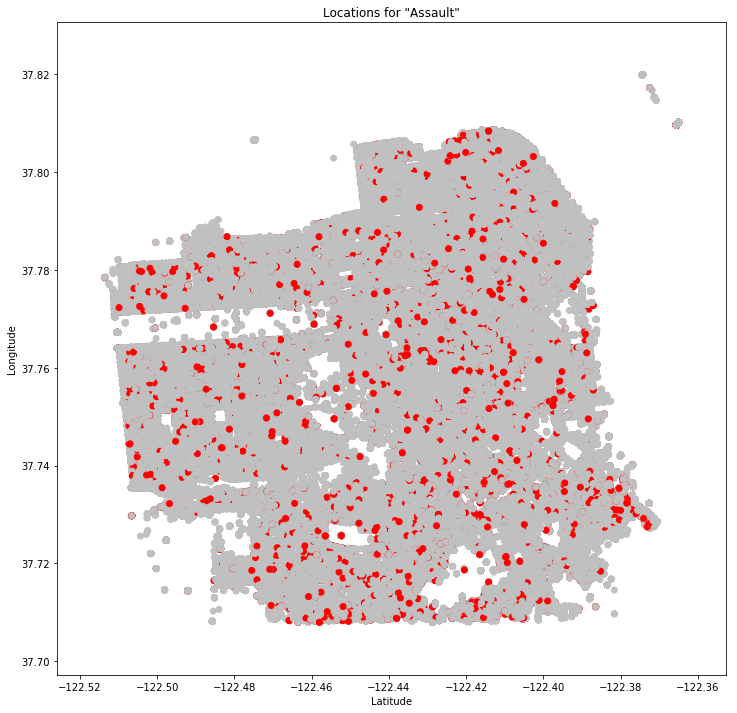

In [42]:
#  Assaults are spread fairly evenly throughout the county
fig = plt.figure(figsize=(12,12))
plt.scatter(train["X"], train["Y"], c=['red' if x=="ASSAULT" else 'silver' for x in train["Category"]])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Locations for "Assault"')
plt.show()

Other offfenses" is a broad category, driven by driving/traffic violations and Evasion of Legal Requirements (eg, Probation Violation, Parole Violation, Violation of Restraining Orders, etc.). It also includes random categories such as "Danger of Leading Immoral Life." Given such breadth, this category may prove difficult to classify.

In [33]:
# Differences in crimes by day of week; crimes peak on Friday see lowest levels on Sunday and rise from Mon-Wed.
train["DayOfWeek"].value_counts()

Friday       133723
Wednesday    129200
Saturday     126804
Thursday     125027
Tuesday      124954
Monday       121573
Sunday       116701
Name: DayOfWeek, dtype: int64

In [34]:
# Top crimes are likely to occur on New Year's Day; the first day of the month also has a propensity for crime.
train["Dates"].value_counts().head(20)

2011-01-01 00:01:00    185
2006-01-01 00:01:00    136
2012-01-01 00:01:00     94
2006-01-01 12:00:00     63
2007-06-01 00:01:00     61
2006-06-01 00:01:00     58
2010-06-01 00:01:00     56
2010-08-01 00:01:00     55
2008-04-01 00:01:00     53
2013-11-01 00:01:00     52
2010-11-01 00:01:00     51
2008-11-01 00:01:00     51
2013-05-01 00:01:00     51
2006-07-01 00:01:00     51
2005-06-01 00:01:00     50
2011-06-01 00:01:00     50
2005-07-01 00:01:00     49
2008-06-01 00:01:00     48
2006-11-01 00:01:00     46
2013-06-01 12:00:00     46
Name: Dates, dtype: int64

In [35]:
# Create new buckets for month, day, year, hour and sesaons to further explore the data.

from datetime import datetime, timedelta, date
import holidays

# extract month, year and hour from both datasets
train["month"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").month)
train["year"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").year)
train["hour"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").hour)
train["day"] = train["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").day)

test["month"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").month)
test["year"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").year)
test["hour"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").hour)
test["day"] = test["Dates"].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").day)

# map holidays
US_Holidays = holidays.UnitedStates()
train["holidays"] = train["Dates"].map(lambda x: x in US_Holidays)
test["holidays"] = test["Dates"].map(lambda x: x in US_Holidays)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [36]:
# Create a dictionary for dayparts

time_periods = {6:"early_morning", 7:"early_morning", 8:"early_morning", 
               9:"late_morning", 10:"late_morning", 11:"late_morning",
              12:"early_afternoon", 13:"early_afternoon", 14:"early_afternoon",
              15:"late_afternoon", 16:"late_afternoon", 17:"late_afternoon",
              18:"early_evening",  19:"early_evening",  20:"early_evening",
              21:"late_evening", 22:"late_evening", 23:"late_evening",
              0:"late_night", 1:"late_night", 2:"late_night",
              3:"late_night", 4:"late_night", 5:"late_night"}

# Map time periods
train["dayparts"] = train["hour"].map(time_periods)
test["dayparts"] = test["hour"].map(time_periods)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [47]:
# There is no clear pattern in crime trends by year, although the most recent year appears to be an outlier.
train["year"].value_counts()

2013    75606
2014    74766
2003    73888
2004    73407
2012    71731
2005    70741
2008    70174
2006    69909
2009    69000
2007    68015
2011    66619
2010    66542
2015    27584
Name: year, dtype: int64

In [48]:
# Further exploration reveals that we only have data through May of 2015.
print((train['month'].loc[train['year'] == 2015]).value_counts())

3    6851
4    6609
2    6008
1    5866
5    2250
Name: month, dtype: int64


In [49]:
# Crimes are most likely to occur on the first day of the month. The 19th-22nd also has several high skewing days.
train["day"].value_counts()

1     32167
22    30587
8     30337
21    30035
19    30011
20    29963
4     29903
18    29790
7     29683
5     29555
23    29542
9     29499
6     29478
17    29028
3     28687
13    28578
10    28395
12    28223
15    28223
16    28146
24    27981
11    27951
14    27668
27    27575
2     27469
28    27265
29    27107
25    26926
26    26870
30    26585
31    14755
Name: day, dtype: int64

In [50]:
# Larceny/Theft is the #1 crime type, and other categories are driving crimes on the 1st day of the month.
print(((train['day'].loc[train['Category'] == "LARCENY/THEFT"]).value_counts()).head(15))

# Therefore, day of the month may help explain other types of offenses.
print(((train['Category'].loc[train['day'] == 1]).value_counts()).head(15))

19    6267
22    6258
21    6108
23    6099
18    6019
20    5991
8     5884
13    5856
17    5823
24    5811
5     5803
7     5768
27    5746
9     5732
29    5692
Name: day, dtype: int64
LARCENY/THEFT             5515
OTHER OFFENSES            4794
NON-CRIMINAL              3716
ASSAULT                   3017
DRUG/NARCOTIC             1821
VEHICLE THEFT             1658
VANDALISM                 1571
SUSPICIOUS OCC            1526
WARRANTS                  1210
BURGLARY                  1193
MISSING PERSON             998
FRAUD                      917
FORGERY/COUNTERFEITING     748
ROBBERY                    742
SECONDARY CODES            446
Name: Category, dtype: int64


In [20]:
# Looking at specific hours, crimes are somewhat more likely to occur after work and during lunchtime.
(train["hour"].value_counts().head(10))  

18    55104
17    53553
12    51934
16    50137
19    49475
15    48058
22    45741
0     44865
20    44694
14    44424
Name: hour, dtype: int64

In [52]:
# Aggregated into buckets, crime skews slightly toward daytime/early evening hours.
train["dayparts"].value_counts()

late_afternoon     151737
early_evening      149256
early_afternoon    139497
late_evening       131857
late_night         125835
late_morning       111725
early_morning       68075
Name: dayparts, dtype: int64

In [53]:
# Overall, 3.2% of all crimes occur on holidays, slightly higher than 10/365 holidays per year (or 2.7%)
train["holidays"].value_counts()

False    849948
True      28034
Name: holidays, dtype: int64

Crime is more prevalent during Winter holidays (excluding December holidays), but this data does not account for 
Christmas eve, New Year's eve and the weekends/weeks surrounding national holidays.

In [54]:
# Crimes during holidays by month
print(((train['month'].loc[train['holidays'] == True]).value_counts()).head(30))

11    4790
1     4638
2     4477
5     3875
9     3862
12    3286
10    2388
7      718
Name: month, dtype: int64
